# **PROYECTO DE PELICULAS-RATINGS**

1. **Importación de librerías**

In [34]:
import pandas as pd #Manipulación y analisis de datos
import logging # sistema de monitoreo
from datetime import datetime, timedelta #fechas
import seaborn as sns # libreria para matriz de correlacion
import matplotlib.pyplot as plt #resto de graficas

2. **Logger**

In [35]:
logging.basicConfig(
    level=logging.INFO,
    format = '%(asctime)s - %(levelname)s - %(message)s',
    force=True
)

logger = logging.getLogger(__name__)

3. **Diagnostico General**

In [36]:
def diagnostico(df,nombre="base",mostrar_head=False):
    """
    Muestra diagnostico de la base de tados
    - cantidad de filas y columnas
    - Columnas con tipo de dato
    - Valores nulos por columna
    """
    logger.info(f"--- Diagnostico de {nombre}")
    logger.info(f"Forma: {df.shape[0]} filas , {df.shape[1]} columnas")
    print("\n--- Tipos de datos ---")
    print(df.dtypes)
    print("\n--- Valores nulos por columna ---")
    print(df.isna().sum())
    logger.info("-" * 50)

    if mostrar_head:
        print("\nPrimeras filas:")

4. **Función para cargar los archivos**

In [37]:
def extraer_datos_csv(archivo):
    """
    Extraemos datos de un archivo CSV.
    
    Arg = ruta del archivo

    Returns: pd.DataFrame : Datos extraídos del archivo
    """
    try:
        #lectura del archivo
        df = pd.read_csv(archivo)

        #monitoreo de archivo
        logger.info(f"Archivo Cargado Correctamente: {archivo}")
        logger.info(f"Registros Extraídos: {len(df)}") #len = largo
        logger.info(f"Columnas: {list(df.columns)}") #List = lista de columnas
        #diagnostico(df,nombre=archivo,mostrar_head=False)


        return df
    
    except FileNotFoundError:
        logger.error(f"Archivo no encontrado:{archivo}")
        return pd.DataFrame()
    except Exception as e:
        logger.error(f"Error leyendo CSV: {str(e)}")
        return pd.DataFrame()   

5. **Función para la unión de las Bases de Datos, mejor medición**

In [38]:
def union(archivo1,archivo2,campo_union):
    try:
        if campo_union not in archivo1.columns or campo_union not in archivo2.columns:
            logger.error(f"La Columna '{campo_union}', no existe en una de las bases")
            return pd.DataFrame()

        Dataset_completo = pd.merge(archivo1,archivo2,on=campo_union,how="inner")

        logger.info(f"Unión completada correctamente:\n Filas: {len(Dataset_completo)}\n,Columnas: {len(Dataset_completo.columns)}")
        logger.info(f"Columnas resultantes: {list(Dataset_completo.columns)}")

        return Dataset_completo
    
    except Exception as e:
        logger.error(f"Error al unir las bases: {str(e)}")
        return pd.DataFrame()

6. **Funcion para la Transformación de Datos**

In [39]:
def Transformacion(dataset):
    logger.info(f"Iniciando Transformaciones básicas:")
    #copiamos el archivo
    dataset = dataset.copy()
    filas_iniciales = dataset.shape[0]

    #Eliminamos duplicados
    dataset = dataset.drop_duplicates()
    logger.info(f"Duplicados exactos eliminados: {filas_iniciales - dataset.shape[0]}")

    #Asegurar datos númericos en IDs y rating
    dataset['moviesId'] = pd.to_numeric(dataset['movieId'],errors='coerce').astype('Int64') #coerce 'Nan'
    dataset['userId'] = pd.to_numeric(dataset['userId'],errors='coerce').astype('Int64')
    dataset['rating'] = pd.to_numeric(dataset['rating'],errors='coerce')

    if 'moviesId' in dataset.columns:
        dataset = dataset.drop(columns=['moviesId'])
        logger.info("Columna 'moviesId' eliminada (columna residual).")

    #Eliminar filas con campos escenciales nulos
    filas = dataset.shape[0]
    dataset = dataset.dropna(subset=['userId','movieId','rating'])
    logger.info(f"Filas eliminadas por userId/movieId/rating nulos: {filas - dataset.shape[0]}")

    #Filtrar rating entre 0.5 y 5
    filas = dataset.shape[0]
    dataset = dataset[(dataset['rating'] >= 0.5) & (dataset['rating'] <=5.0)]
    logger.info(f"Filas eliminadas por rating fuera de rango: {filas - dataset.shape[0]}")

    #Convertir fechas y extraer año y mes
    if 'timestamp' in dataset.columns:
        
        if pd.api.types.is_numeric_dtype(dataset['timestamp']):
            #convertir a fecha real
            dataset['nueva_fecha'] = pd.to_datetime(dataset['timestamp'], unit='s', errors='coerce')
        else:
            dataset['nueva_fecha'] = pd.to_datetime(dataset['timestamp'], errors='coerce')
        
        logger.info(f"Registros nulos después de conversión: {dataset['nueva_fecha'].isna().sum()}")
        
        dataset['año'] = dataset['nueva_fecha'].dt.year
        dataset['mes'] = dataset['nueva_fecha'].dt.month
    else:
        logger.info("No se encontro columna 'timestamp' para convertir")
    
    #Normalizar titulos y generos
    if 'title' in dataset.columns:
        dataset['title'] = dataset['title'].astype(str).str.strip() #strip elimina espacios
    if 'genres' in dataset.columns:
        dataset['genres'] = dataset['genres'].fillna('').astype(str) #rellena vacions con ' '

    #Resultado final

    logger.info(f"Transformaciones realizadas: Dataset Final {dataset.shape}")
    logger.info(f"Usuarios únicos: {dataset['userId'].nunique()} | películas únicas: {dataset['movieId'].nunique()}")
    diagnostico(dataset,nombre=dataset,mostrar_head=True)

    return dataset


7. **Función de carga de datos**

In [40]:
def carga_de_datos(structured_data, load_type='full'):

    try:
        logger.info(f"Iniciando carga de datos - Tipo: {load_type}")

        #validación

        if structured_data.empty:
            logger.warning("No hay datos para guardar")
            return False
        
        print("Validaciones Precarga")
        print(f"Registros a cargar: {len(structured_data)}")
        print(f"Columnas: {list(structured_data.columns)}")

        #verificacíon de duplicados

        duplicados = structured_data.duplicated(subset=['userId','movieId','timestamp']).sum()

        if duplicados > 0:
            print(f"{duplicados} registros duplicados encontrados")
            structured_data = structured_data.drop.duplicates(
                subset=['userId','movieId','timestamp'], keep='last'
            )

        #Simular cargas

        #1. Carga Completa

        if load_type == 'full':
            filename = 'warehouse_ratings_full.csv'
            structured_data.to_csv(filename, index=False)
            print(f"Carga completa realizada: {filename}")
        
        #2. Incremental
        elif load_type == 'incremental':
            filename = 'warehouse_ratings_incremental.csv'
            structured_data.to_csv(filename, mode='a',header=False, Index=False)
            print(f"Carga incremental realizada: {filename}")

        elif load_type == 'upsert':
            filename = 'warehouse_ratings_upset.csv'
            structured_data.to_csv(filename, index=False)
            print(f"Upsert realizado: {filename}")

        print("\n...Datos Cargados\n")
        print(f"Regsitros Cargados: {len(structured_data)}")
        #print("\nPrimeras filas")
        #print(structured_data.head())

        print("\n-----Estadisticas-----")
        print(f"Total de usuarios: {structured_data['userId'].nunique()}")
        print(f"Total de películas: {structured_data['movieId'].nunique()}")
        print(f"Rating promedio : {structured_data['rating'].mean():.2f}")

        logger.info("Carga exitosa....")
        return True
    
    except Exception as e:
        logger.error(f"Error en la carga {str(e)}")
        return False

8. **Función de graficos**

In [41]:
def graficos(df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 filas x 3 columnas
    fig.suptitle("Análisis Exploratorio de Ratings", fontsize=16, fontweight="bold")

    # 1. Distribución de Ratings
    df['rating'].hist(bins=10, edgecolor='black', ax=axes[0,0])
    axes[0,0].set_title("Distribución de Ratings")
    axes[0,0].set_xlabel("Rating")
    axes[0,0].set_ylabel("Frecuencia")

    # 2. Distribución porcentual (torta)
    ratings_counts = df['rating'].value_counts(normalize=True).sort_index()
    axes[0,1].pie(
        ratings_counts,
        labels=ratings_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False,
        wedgeprops={'edgecolor': 'white'}
    )
    axes[0,1].set_title("Distribución porcentual de Ratings")

    # 3. Ratings por año
    if 'año' in df.columns:
        ratings_por_año = df.groupby('año')['rating'].count()
        ratings_por_año.plot(kind='bar', ax=axes[0,2], color='skyblue')
        axes[0,2].set_title("Ratings por año")
        axes[0,2].set_xlabel("Año")
        axes[0,2].set_ylabel("Cantidad de Ratings")
        axes[0,2].ticklabel_format(style='plain', axis='y')

    # 4. Top 10 Películas
    top_peliculas = df['title'].value_counts().head(10)
    top_peliculas.plot(kind='barh', ax=axes[1,0], color="orange")
    axes[1,0].set_title("Top 10 Películas con más calificaciones")
    axes[1,0].set_xlabel("Cantidad de Ratings")
    axes[1,0].set_ylabel("Película")

    # 5. Matriz de Correlación
    numeric_df = df[['rating','año','mes']].copy()
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[1,1])
    axes[1,1].set_title("Matriz de Correlación")

    #6. Promedio ratings por año
    if 'año' in df.columns:
            promedio_por_año = df.groupby('año')['rating'].mean()
            promedio_por_año.plot(kind='line', marker='o', color="red")
            plt.title("Promedio de Ratings por Año")
            plt.xlabel("Año")
            plt.ylabel("Rating Promedio")
            plt.ylim(0,5)
            plt.xlim(1994,2016)
            plt.grid(True)
            plt.show()

    plt.tight_layout(pad=4.0)  # deja espacio al título
    plt.show()


In [42]:
def graficos1(df):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))  # 2 filas x 3 columnas
    fig.suptitle("Análisis Exploratorio de Ratings", fontsize=16, fontweight="bold")

    # 3. Ratings por año
    if 'año' in df.columns:
        ratings_por_año = df.groupby('año')['rating'].count()
        ratings_por_año.plot(kind='bar', ax=axes[0,2], color='skyblue')
        axes[0,2].set_title("Ratings por año")
        axes[0,2].set_xlabel("Año")
        axes[0,2].set_ylabel("Cantidad de Ratings")
        axes[0,2].ticklabel_format(style='plain', axis='y')

    # 4. Top 10 Películas
    top_peliculas = df['title'].value_counts().head(10)
    top_peliculas.plot(kind='barh', ax=axes[1,0], color="orange")
    axes[1,0].set_title("Top 10 Películas con más calificaciones")
    axes[1,0].set_xlabel("Cantidad de Ratings")
    axes[1,0].set_ylabel("Película")

    plt.tight_layout(pad=4.0)  # deja espacio al título
    plt.show()

In [43]:
def graficos2(df):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))  # 2 filas x 3 columnas
    fig.suptitle("Análisis Exploratorio de Ratings", fontsize=16, fontweight="bold")

    # 5. Matriz de Correlación
    numeric_df = df[['movieId', 'rating', 'año']].copy()
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[1,1])
    axes[1,1].set_title("Matriz de Correlación")

    # 6. primedio de ratings por año
    if 'año' in df.columns:
        promedio_por_año = df.groupby('año')['rating'].mean()
        promedio_por_año.plot(kind='line', marker='o', color="red")
        plt.title("Promedio de Ratings por Año")
        plt.xlabel("Año")
        plt.ylabel("Rating Promedio")
        plt.ylim(0,5)
        plt.xlim(1994,2016)
        plt.grid(True)
        plt.show()

    plt.tight_layout(pad=4.0)  # deja espacio al título
    plt.show()

9. **Función de PIPELINE**

In [44]:
def etl():
    """
    Monitoreo Completo para el Dataset Movie y rating
    """
    tiempo_inicial = datetime.now()

    try:
        print("Iniciando Pipeline ETL")
        print(f"Hora de inicio: {tiempo_inicial}")
        print("=" * 50)

        #Extraer
        movies_df = extraer_datos_csv("movie.csv")
        rating_df = extraer_datos_csv("rating.csv")

        #Transformar
        base_unida = union(movies_df,rating_df,"movieId")
        #diagnostico(base_unida,"base_unida",mostrar_head=False)
        base_limpia = Transformacion(base_unida)
        #diagnostico(base_limpia,"base_limpia",mostrar_head=True)
        
        #Carga de datos
        completo = carga_de_datos(base_limpia,load_type='full')

        #Metricas finales
        tiempo_final = datetime.now()
        duracion = tiempo_final-tiempo_inicial

        print("\n" + "=" * 50 )
        print("RESUMEN DEL PIPELINE ETL")
        print("=" * 50)
        print(f"Estado: {'EXITOSO' if completo else 'FALLIDO'}")
        print(f"Duración: {duracion.total_seconds():.2f} segundos")
        print(f"Registros extraidos: {len(base_unida)}")
        print(f"Registros procesados y cargados: {len(base_limpia)}")
        print(f"Tasa de filtrado: {(((len(base_unida)-len(base_limpia))/len(base_unida))*100):.1f}%")

        graficos(base_limpia)                

        return base_limpia
    
    except Exception as e:
        logger.error(f"Falla en el pipeline {str(e)}")
        print(f"error en el Pipeline {str(e)}")
        return None

8. **Ejecutar el Pipeline**

2025-09-19 20:44:05,343 - INFO - Archivo Cargado Correctamente: movie.csv
2025-09-19 20:44:05,345 - INFO - Registros Extraídos: 27278
2025-09-19 20:44:05,346 - INFO - Columnas: ['movieId', 'title', 'genres']


Iniciando Pipeline ETL
Hora de inicio: 2025-09-19 20:44:05.282166


2025-09-19 20:44:41,252 - INFO - Archivo Cargado Correctamente: rating.csv
2025-09-19 20:44:41,254 - INFO - Registros Extraídos: 20000263
2025-09-19 20:44:41,256 - INFO - Columnas: ['userId', 'movieId', 'rating', 'timestamp']
2025-09-19 20:45:24,174 - INFO - Unión completada correctamente:
 Filas: 20000263
,Columnas: 6
2025-09-19 20:45:24,275 - INFO - Columnas resultantes: ['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp']
2025-09-19 20:45:24,299 - INFO - Iniciando Transformaciones básicas:
2025-09-19 20:46:41,695 - INFO - Duplicados exactos eliminados: 0
2025-09-19 20:46:48,089 - INFO - Columna 'moviesId' eliminada (columna residual).
2025-09-19 20:46:53,175 - INFO - Filas eliminadas por userId/movieId/rating nulos: 0
2025-09-19 20:46:57,969 - INFO - Filas eliminadas por rating fuera de rango: 0
2025-09-19 20:47:40,259 - INFO - Registros nulos después de conversión: 0
2025-09-19 20:47:59,546 - INFO - Transformaciones realizadas: Dataset Final (20000263, 9)
2025-09-19 20:4


--- Tipos de datos ---
movieId                 int64
title                  object
genres                 object
userId                  Int64
rating                float64
timestamp              object
nueva_fecha    datetime64[ns]
año                     int32
mes                     int32
dtype: object

--- Valores nulos por columna ---


2025-09-19 20:48:14,205 - INFO - --------------------------------------------------
2025-09-19 20:48:14,206 - INFO - Iniciando carga de datos - Tipo: full


movieId        0
title          0
genres         0
userId         0
rating         0
timestamp      0
nueva_fecha    0
año            0
mes            0
dtype: int64

Primeras filas:
Validaciones Precarga
Registros a cargar: 20000263
Columnas: ['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp', 'nueva_fecha', 'año', 'mes']
Carga completa realizada: warehouse_ratings_full.csv

...Datos Cargados

Regsitros Cargados: 20000263

-----Estadisticas-----
Total de usuarios: 138493
Total de películas: 26744


2025-09-19 20:54:24,757 - INFO - Carga exitosa....


Rating promedio : 3.53

RESUMEN DEL PIPELINE ETL
Estado: EXITOSO
Duración: 619.48 segundos
Registros extraidos: 20000263
Registros procesados y cargados: 20000263
Tasa de filtrado: 0.0%


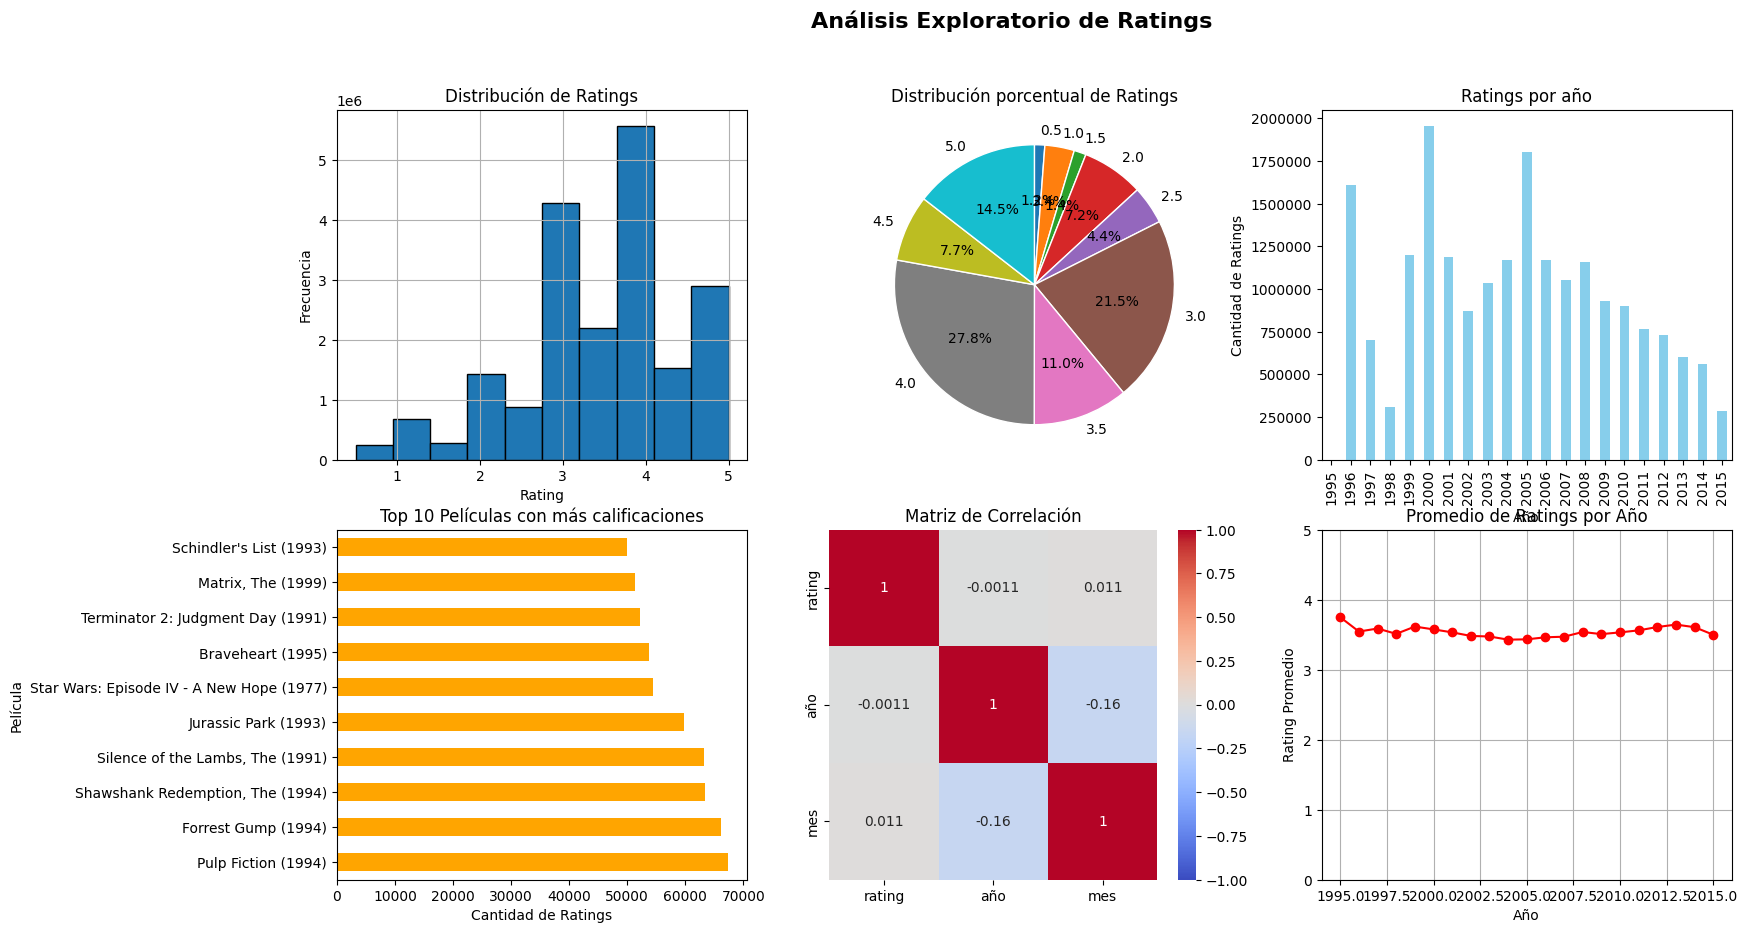

<Figure size 640x480 with 0 Axes>

In [45]:
resultado = etl()

## **Conclusiones**

1. Los usuarios califican entre 3 y 4 a la mayoría de las peliculas, cuyo porcentaje es aproximadamente el 50% de las calificaciones.
2. La pelicula mejor calificada Corresponde a **PULP FICTION** de 1994
3. Se observa la tendencia en que las peliculas mas actuales (Entre 2006 y 2015) son menos calificadas que las mas antiguas.
4. El promedio de calificaciones globales se encuentra entre 3 y 4.

## Funciones Individuales (Prueba)
6. **Carga de los archivos de Dataset**

In [46]:
movies_df = extraer_datos_csv("movie.csv")
rating_df = extraer_datos_csv("rating.csv")

2025-09-19 20:54:42,793 - INFO - Archivo Cargado Correctamente: movie.csv
2025-09-19 20:54:42,797 - INFO - Registros Extraídos: 27278
2025-09-19 20:54:42,799 - INFO - Columnas: ['movieId', 'title', 'genres']
2025-09-19 20:55:19,574 - INFO - Archivo Cargado Correctamente: rating.csv
2025-09-19 20:55:19,578 - INFO - Registros Extraídos: 20000263
2025-09-19 20:55:19,583 - INFO - Columnas: ['userId', 'movieId', 'rating', 'timestamp']


7. **Unión de las bases de datos**

In [47]:
base_unida = union(movies_df,rating_df,"movieId")

logger.info(f"Archivo Unido:\n{base_unida.head()}")

2025-09-19 20:56:13,772 - INFO - Unión completada correctamente:
 Filas: 20000263
,Columnas: 6
2025-09-19 20:56:13,919 - INFO - Columnas resultantes: ['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp']
2025-09-19 20:56:29,125 - INFO - Archivo Unido:
   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating            timestamp  
0       3     4.0  1999-12-11 13:36:47  
1       6     5.0  1997-03-13 17:50:52  
2       8     4.0  1996-06-05 13:37:51  
3      10     4.0  1999-11-25 02:44:47  
4      11     4.5  2009-01-02 01:13:41  


8. **Determinar Tipos de datos**

In [48]:
diagnostico(base_unida,"base_unida")

2025-09-19 20:56:29,444 - INFO - --- Diagnostico de base_unida
2025-09-19 20:56:29,450 - INFO - Forma: 20000263 filas , 6 columnas



--- Tipos de datos ---
movieId        int64
title         object
genres        object
userId         int64
rating       float64
timestamp     object
dtype: object

--- Valores nulos por columna ---


2025-09-19 20:56:37,311 - INFO - --------------------------------------------------


movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64


9. **Transformación de datos**

In [49]:
base_limpia = Transformacion(base_unida)

2025-09-19 20:56:37,491 - INFO - Iniciando Transformaciones básicas:


KeyboardInterrupt: 

10. **Validación Datos Base Transformada**

In [ ]:
diagnostico(base_limpia,"base_limpia")